The data I used is price data for apartments on Kungsholmen in Stockholm, Sweden. It includes date of sale and final price along with some information about the apartment, like for example address, size in square meters, number of rooms and fee.

I'm currently looking to buy an apartment in this area and wanted to try to use the data to help me value apartments I'm interested in. Since we're also living in the middle of a global pandemic I wanted to see if there were any evidence of the virus affecting apartment prices. If the pandemic seems to have had an effect, I want to see if it's affecting the market as a whole or if there are any other interesting patterns to be seen.

I acquired the data in the form of 25 json files which contained data for a small part of Kungsholmen and some of the data was duplicated in different files. I have a background in web development and feel much more comfortable writing JavaScript than Python, I wanted to get started looking at the quickly so I did the merging and cleaning of the files in JS. The script datasets/merge-and-clean.js outputs apartment-prices.csv.

In [1]:
# lets take a look at the data
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from read_prices import read_prices
from scatter import price_scatter_plot
df = read_prices()
print(df.head())

        id                               coordinate                   address  \
0  1123282   [59.33695736385066,18.025530244563154]      Svarvargatan 3, 2 tr   
1  1139756   [59.32892343420378,18.019346434686543]  Gjörwellsgatan 15, 1 trp   
2  1139783  [59.327111962896275,18.009479044477448]         Atterbomsvägen 30   
3  1139829   [59.32885285266372,18.041304332706463]   Södra Agnegatan 20, 3tr   
4  1139903    [59.3264370094667,18.021165456974373]  Fyrverkarbacken 23, 3 tr   

            typeSummary     iconName           location_name    price  \
0  Bostadsrättslägenhet  bostadsratt  Kungsholmen, Stockholm  3650000   
1  Bostadsrättslägenhet  bostadsratt  Kungsholmen, Stockholm  4050000   
2  Bostadsrättslägenhet  bostadsratt     Fredhäll, Stockholm  2500000   
3  Bostadsrättslägenhet  bostadsratt  Kungsholmen, Stockholm  7700000   
4  Bostadsrättslägenhet  bostadsratt  Kungsholmen, Stockholm  2950000   

         formatted_price  price_per_area   fee  ...  \
0  Slutpris 3 650 0

There was quite a bit of cleaning up needed since the data was formatted to be displayed on a web page. The price, fee and size all had formatting, so I stripped them of all characters but the digits. The floor is included in the address, but different brokers use different formats so some RegEx magic was needed to get the floor number.

To be able to see data for individual streets, I defined street_id as the street name stripped of all non-letter characters. To use the street name in the regression I ended up using the normalized mean of the price per square meter of the street. This way the more popular streets would get a street_attractiveness value closer to 1, and cheap streets would get a value close to 0. 

Streets could of course have been categorical values too, but found this method of using the streets' mean price to be more accurate.

In [2]:
# here's a look at the most expensive and cheapest streets
print("Most expensive streets", df.groupby('street_id').price_per_area.mean().astype(int).sort_values(ascending=False).head(), "\n")
print("Cheapest streets", df.groupby('street_id').price_per_area.mean().astype(int).sort_values(ascending=True).head())

Most expensive streets street_id
skillinggrnd          110398
parkgatan             108071
chapmansgatan         106165
kungsholmshamnplan    104330
kronobergsgatan       104199
Name: price_per_area, dtype: int64 

Cheapest streets street_id
runiusgatan          69481
kristinebergsvgen    70099
nicandervgen         70213
wennerbergsgatan     71368
geijersvgen          71537
Name: price_per_area, dtype: int64


The covid data was more straight forward, I collected it from Our World In Data. The dataset includes countries' total deaths by date.

Here's a look at how Kungsholmen apartments faired during the last 12 months, along with Sweden's total covid deaths.

Price change: 4 %


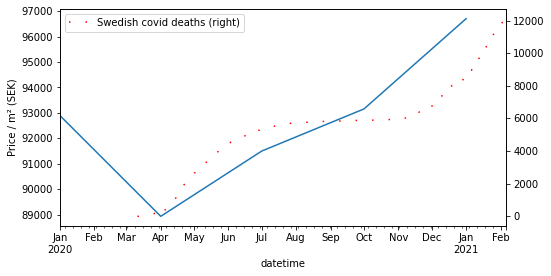

In [3]:
# i wanted to keep the notebook clean, so the bulk of the code is in other files
# look in price_vs_covid.py for more comments on the code
from price_vs_covid import plot_apartment_price_vs_covid_deaths
plot_apartment_price_vs_covid_deaths(df)

So it certainly seems like the market was chocked when the pandemic started to spread to Sweden. Quite interestingly the mean price recovered quickly and ended the year higher than it started.

So to answer the question if the market was affected, it certainly was. But maybe only for a few months? Let's dive deeper.

0 to 25 m² - Price Q1 2020: 121662 SEK/m², Price Q1 2021: 112888 SEK/m², Change: -7 %
26 to 50 m² - Price Q1 2020: 93740 SEK/m², Price Q1 2021: 97367 SEK/m², Change: 3 %
51 to 150 m² - Price Q1 2020: 88229 SEK/m², Price Q1 2021: 92376 SEK/m², Change: 4 %


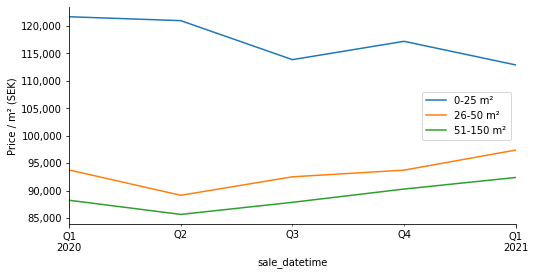

In [4]:
from size_vs_covid import plot_price_timeline_for_apartment_sizes
plot_price_timeline_for_apartment_sizes(df)

This suggests an interesting affect covid may have had on Kungsholmen apartment prices: Prices of the very smallest apartments (<25 m²) decreased by 7% during the last 12 months even though prices as a whole rose by x%.

As I said I'm currently looking for an apartment in this area, so I'd like to try and predict prices for the apartments I'm viewing. I mean I have to make sure I don't pay way too much! :)

Probably the most obvious feature that definitely affects price is the size of the apartment.

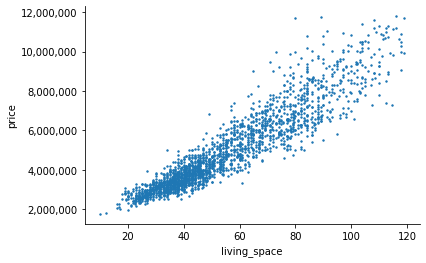

In [5]:
price_scatter_plot(df, xaxis='living_space', yaxis='price')

Another obvious feature is location. As discussed above I defined street_attractiveness as the normalized mean price per square meter of the street. I think it's an alright way to factor in location as it will take into account that two streets may have very different prices even though they are geographically close. An example could be two parallell streets where one street faces a river, while the other faces a heavily trafficked street.

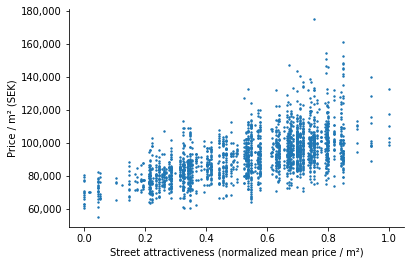

In [6]:
price_scatter_plot(df, xaxis="street_attractiveness", yaxis="price_per_area", xlabel="Street attractiveness (normalized mean price / m²)", ylabel="Price / m² (SEK)")

There's definitely a noticable difference in price between streets, so I decided to include this metric. 

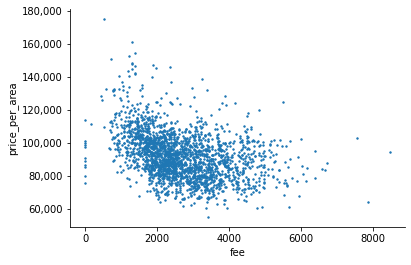

In [7]:
price_scatter_plot(df, xaxis='fee', yaxis='price_per_area')

The fee negatively correlates to price per square meter. That seems reasonable considering a higher fee means the cost of living increases, which impacts the size of the mortage you're able to get. The fee also covers loans on the building, so a high fee often means high debt which of course would lower the valuation of the apartments in the building.

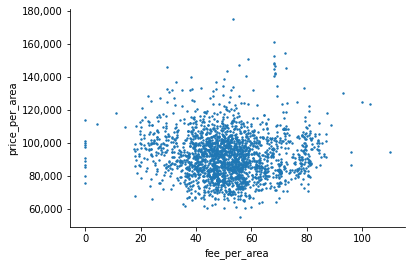

In [8]:
price_scatter_plot(df, xaxis='fee_per_area', yaxis='price_per_area')

At first I considered using fee / size, since that seems like a better comparison between different sized apartments. But it turns out the correlation is gone, or at least much weaker when accounting for size. But I guess it makes sense that the full amount is what matters, since that is the input into the mortage calculation.

Anyway, time for regression!

John Bergs plan 3 (3262799, 90633)
R2-Score: 0.9172162189722946


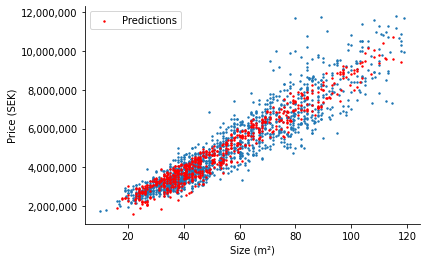

In [9]:
from predict import plot_regression

plot_regression(df)

Looks alright! Let's try it out on a few very recent prices not included in the data.

In [14]:
from predict import predict

print("Pipersgatan 18", predict(df, 3062, 37.5, 3, 'pipersgatan'), 'Actual price: 3750000')
print("Vitalisvägen 4", predict(df, 2335, 43, 3, 'vitalisvgen'), 'Actual price: 3630000')
print("Inedalsgatan 15", predict(df, 1623, 23, 3, 'inedalsgatan'), 'Actual price: 3150000')
print("Frödingsvägen 6", predict(df, 2161, 53, 3, 'frdingsvgen'), 'Actual price: 4300000')
print("Ivan Oljelunds Gränd 1", predict(df, 4680, 87, 2, 'ivanoljelundsgrnd'), 'Actual price: 8150000')

Pipersgatan 18 (4005382, 106810) Actual price: 3750000
Vitalisvägen 4 (3415047, 79419) Actual price: 3630000
Inedalsgatan 15 (2723384, 118408) Actual price: 3150000
Frödingsvägen 6 (4573755, 86297) Actual price: 4300000
Ivan Oljelunds Gränd 1 (7553524, 86822) Actual price: 8150000


Those are some alright predictions. Obviously not perfect, but they're in the ballpark. I probably shouldn't rely to heavily on this regression model when valuing apartments for my personal purchase though :)